# General parameters

In [1]:
import files
import utils
import os
import models
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import datetime
import seaborn as sns

/Users/mzaffran/Documents/Code/CP/cp-epf-clean/models.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import matplotlib as mpl
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pdf', FigureCanvasPgf)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset,inset_axes

size=19
mpl.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.serif': 'Times',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': size,
    'axes.labelsize':size,
    'axes.titlesize':size,
    'figure.titlesize':size,
    'xtick.labelsize':size,
    'ytick.labelsize':size,
    'legend.fontsize':size,
})

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

In [3]:
#########################################################
# Global random forests parameters
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = 6

params_basemodel = {'n_estimators':n_estimators, 'min_samples_leaf':min_samples_leaf, 'max_features':max_features,
                    'cores':1}

# Data import

In [4]:
# load the dataset

data = pd.read_csv("data_prices/Prices_2016_2019_extract.csv")

In [5]:
data.shape
# the first week (24*7 rows) has been removed because of the lagged variables.

(34896, 59)

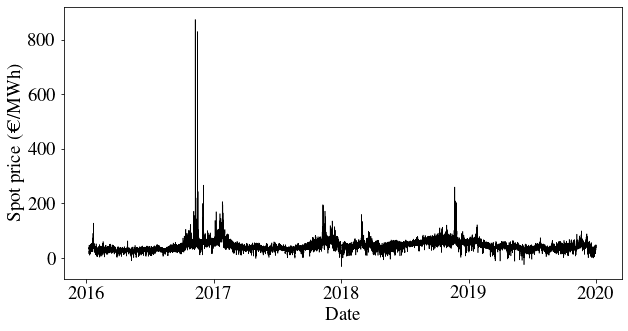

In [6]:
date_plot = pd.to_datetime(data.Date)

plt_1 = plt.figure(figsize=(10, 5))
plt.plot(date_plot, data.Spot, color='black', linewidth=0.6)
locs, labels = plt.xticks()
plt.xticks(locs[0:len(locs):2], labels=['2016','2017','2018','2019','2020'])
plt.xlabel('Date')
plt.ylabel('Spot price (\u20AC/MWh)')
plt.show()

In [7]:
limit = datetime.datetime(2019, 1, 1, tzinfo=datetime.timezone.utc)
id_train = data.index[pd.to_datetime(data['Date'], utc=True) < limit].tolist()
data_train = data.iloc[id_train,:]
sub_data_train = data_train.loc[:,['hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6'] + 
                                  ['lag_24_%d'%i for i in range(24)] +
                                  ['lag_168_%d'%i for i in range(24)] + ['conso']]
all_x_train = [np.array(sub_data_train.loc[sub_data_train.hour == h]) for h in range(24)]

train_size = all_x_train[0].shape[0]

In [8]:
sub_data = data.loc[:,['hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6'] + 
                       ['lag_24_%d'%i for i in range(24)] +
                       ['lag_168_%d'%i for i in range(24)] + ['conso']]
all_x = [np.array(sub_data.loc[sub_data.hour == h]) for h in range(24)]

all_y = [np.array(data.loc[data.hour == h, 'Spot']) for h in range(24)]

In [9]:
all_x_train[0].shape

(1089, 57)

# CP methods

In [10]:
alpha = 0.1

In [11]:
for h in tqdm(range(24)):
    
    X = all_x[h]
    Y = all_y[h]

    data_dict = {'X': np.transpose(X), 'Y': Y}

    dataset = 'Spot_France_Hour_'+str(h)+'_train_'+str(limit)[:10]

    methods = ['CP', 'EnbPI']
    
    params_methods = {'B': 30}

    results, methods_ran = models.run_experiments_real_data(data_dict, alpha, methods, params_methods, 'RF', params_basemodel,
                                                            train_size, dataset, erase=False)

    for method in methods_ran:
            name_dir, name_method = files.get_name_results(method, dataset=dataset)
            results_method = results[method]
            files.write_file('results/'+name_dir, name_method, 'pkl', results_method)
     
    # Mean EnbPI
    
    params_methods = {'B': 30, 'mean': True}

    results, methods_ran = models.run_experiments_real_data(data_dict, alpha, methods, params_methods, 'RF', params_basemodel,
                                                            train_size, dataset, erase=False)

    for method in methods_ran:
            name_dir, name_method = files.get_name_results(method, dataset=dataset)
            results_method = results[method]
            files.write_file('results/'+name_dir, name_method, 'pkl', results_method)
            
    # Offline
            
    methods = ['CP']
    params_methods = {'online': False}

    results, methods_ran = models.run_experiments_real_data(data_dict, alpha, methods, params_methods, 'RF', params_basemodel,
                                                          train_size, dataset, erase=False)

    for method in methods_ran:
            name_dir, name_method = files.get_name_results(method, online=False, dataset=dataset)
            results_method = results[method]
            files.write_file('results/'+name_dir, name_method, 'pkl', results_method)

In [12]:
tab_gamma = [0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

for h in tqdm(range(24)):
    
    X = all_x[h]
    Y = all_y[h]

    data_dict = {'X': np.transpose(X), 'Y': Y}

    dataset = 'Spot_France_Hour_'+str(h)+'_train_'+str(limit)[:10]

    
    results, methods_ran = models.run_multiple_gamma_ACP_real_data(data_dict, alpha, tab_gamma, 'RF', 
                                                                   params_basemodel, train_size, dataset,
                                                                   erase=False)
    
    online = True
    for method in methods_ran:
            name_dir, name_method = files.get_name_results(method, dataset=dataset)
            results_method = results[method]
            files.write_file('results/'+name_dir, name_method, 'pkl', results_method)

## Results concatenated

Be careful that the aggregation algorithm (AgACI) must be run in R separately from this notebook before running the following cells (if you use a new data set or if you erased the supplied results).

In [13]:
id_test = data.index[pd.to_datetime(data['Date'], utc=True) >= limit].tolist()

data_test = data.iloc[id_test,:]

In [14]:
methods = ['CP','EnbPI','EnbPI_Mean']+['ACP_'+str(gamma) for gamma in tab_gamma]+['Aggregation_EWA_Gradient','Aggregation_EWA',
           'Aggregation_MLpol_Gradient','Aggregation_MLpol',
           'Aggregation_BOA_Gradient','Aggregation_BOA']

In [15]:
for method in methods:
    
    y_upper = [None]*data_test.shape[0]
    y_lower = [None]*data_test.shape[0]

    for i in range(24):
        dataset = 'Spot_France_Hour_'+str(i)+'_train_'+str(limit)[:10]

        name_dir, name_method = files.get_name_results(method, dataset=dataset)
        results = files.load_file('results/'+name_dir, name_method, 'pkl')

        y_upper[i::24] = list(results['Y_sup'].reshape(1,-1)[0])
        y_lower[i::24] = list(results['Y_inf'].reshape(1,-1)[0])

    y_upper = np.array(y_upper)
    y_lower = np.array(y_lower)

    results_method = {'Y_inf': y_lower, 'Y_sup':y_upper}
    dataset = 'Spot_France_ByHour_train_'+str(limit)[:10]
    name_dir, name_method = files.get_name_results(method, dataset=dataset)
    if not os.path.isdir('results/'+name_dir):
        os.mkdir('results/'+name_dir)
    files.write_file('results/'+name_dir, name_method, 'pkl', results_method)
    
    if method == 'CP':
        y_upper = [None]*data_test.shape[0]
        y_lower = [None]*data_test.shape[0]

        for i in range(24):
            dataset = 'Spot_France_Hour_'+str(i)+'_train_'+str(limit)[:10]

            name_dir, name_method = files.get_name_results(method, online=False, dataset=dataset)
            results = files.load_file('results/'+name_dir, name_method, 'pkl')

            y_upper[i::24] = list(results['Y_sup'].reshape(1,-1)[0])
            y_lower[i::24] = list(results['Y_inf'].reshape(1,-1)[0])

        y_upper = np.array(y_upper)
        y_lower = np.array(y_lower)

        results_method = {'Y_inf': y_lower, 'Y_sup':y_upper}
        dataset = 'Spot_France_ByHour_train_'+str(limit)[:10]
        name_dir, name_method = files.get_name_results(method, online=False, dataset=dataset)
        if not os.path.isdir('results/'+name_dir):
            os.mkdir('results/'+name_dir)
        files.write_file('results/'+name_dir, name_method, 'pkl', results_method)

In [16]:
dataset = 'Spot_France_ByHour_train_'+str(limit)[:10]

Y = data_test['Spot'].values

### Visualisation

In [17]:
colors_blindness = sns.color_palette("colorblind")

In [18]:
method = 'Aggregation_BOA_Gradient'
name_dir, name_method = files.get_name_results(method, dataset=dataset)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
contains = (Y <= results['Y_sup']) & (Y >= results['Y_inf'])
lengths = results['Y_sup'] - results['Y_inf']
y_pred = (results['Y_sup'] + results['Y_inf'])/2

In [19]:
d = 20

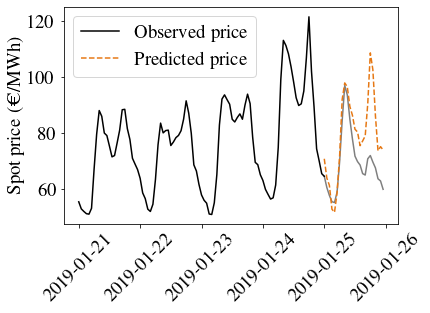

In [20]:
plt.plot(pd.to_datetime(data_test['Date'])[24*d:(24*(d+4)+1)],data_test['Spot'][24*d:(24*(d+4)+1)], color='black', 
         label='Observed price')
plt.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],data_test['Spot'][24*(d+4):24*(d+5)],
         color='black',alpha=.5)
plt.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],y_pred[24*(d+4):24*(d+5)],'--',
         color=(230/255,120/255,20/255), label='Predicted price')
plt.ylabel("Spot price (€/MWh)")
plt.xticks(rotation=45)
plt.legend()
#plt.savefig('plots/prices/spot_last.png', bbox_inches='tight',dpi=300)
plt.show()

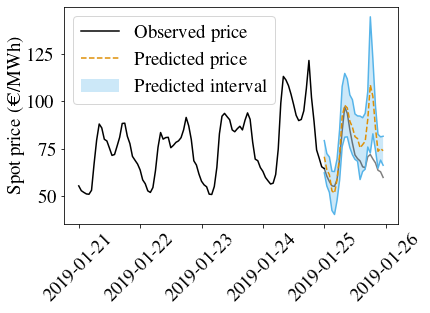

In [21]:
plt.plot(pd.to_datetime(data_test['Date'])[24*d:(24*(d+4)+1)],data_test['Spot'][24*d:(24*(d+4)+1)], color='black',
         label='Observed price')
plt.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],data_test['Spot'][24*(d+4):24*(d+5)],
         color='black', alpha=.5)
plt.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],results['Y_sup'][24*(d+4):24*(d+5)],
         color=colors_blindness[9])
plt.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],results['Y_inf'][24*(d+4):24*(d+5)],
         color=colors_blindness[9])
plt.fill_between(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],results['Y_sup'][24*(d+4):24*(d+5)], 
                 results['Y_inf'][24*(d+4):24*(d+5)], 
                 alpha=.3, fc=colors_blindness[9], ec='None', label='Predicted interval')
plt.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],y_pred[24*(d+4):24*(d+5)],'--',
         color=colors_blindness[1], label='Predicted price')
plt.ylabel("Spot price (€/MWh)")
plt.xticks(rotation=45)
plt.legend()
#plt.savefig('plots/prices/ex_int_'+method+'.pdf', bbox_inches='tight',dpi=300)
plt.show()

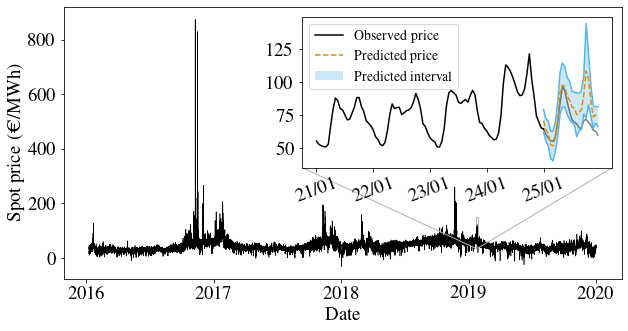

In [22]:
date_plot = pd.to_datetime(data.Date)


fig,ax = plt.subplots(1,1,figsize=(10, 5))

axins = inset_axes(ax,4.3,2.1,loc='upper right')


ax.plot(date_plot, data.Spot, color='black', linewidth=0.6)
locs = ax.get_xticks()
ax.set_xticks(locs[0:len(locs):2])
ax.set_xticklabels(['2016','2017','2018','2019','2020'])
ax.set_xlabel('Date')
ax.set_ylabel('Spot price (\u20AC/MWh)')

axins.plot(pd.to_datetime(data_test['Date'])[24*d:(24*(d+4)+1)],data_test['Spot'][24*d:(24*(d+4)+1)], color='black',
         label='Observed price')
axins.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],data_test['Spot'][24*(d+4):24*(d+5)],
         color='black', alpha=.5)
axins.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],results['Y_sup'][24*(d+4):24*(d+5)],
         color=colors_blindness[9])
axins.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],results['Y_inf'][24*(d+4):24*(d+5)],
         color=colors_blindness[9])
axins.fill_between(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],results['Y_sup'][24*(d+4):24*(d+5)], 
                 results['Y_inf'][24*(d+4):24*(d+5)], 
                 alpha=.3, fc=colors_blindness[9], ec='None', label='Predicted interval')
axins.plot(pd.to_datetime(data_test['Date'])[24*(d+4):24*(d+5)],y_pred[24*(d+4):24*(d+5)],'--',
         color=colors_blindness[1], label='Predicted price')
axins.legend(prop={'size': 14})

axins.set_yticks([50,75,100,125])
axins.set_yticklabels([50,75,100,125])
locs = axins.get_xticks()
axins.set_xticks(locs[:len(locs)-1])
axins.set_xticklabels(['21/01','22/01','23/01','24/01','25/01'])
axins.tick_params(axis='x', rotation=20)
mark_inset(ax, axins, loc1=3, loc2=4, fc="none", ec="0.7")

#plt.savefig('plots/prices/spot_and_ex_int_'+method+'.pdf', bbox_inches='tight',dpi=300)

plt.show()

### Marginal validity and efficiency comparison

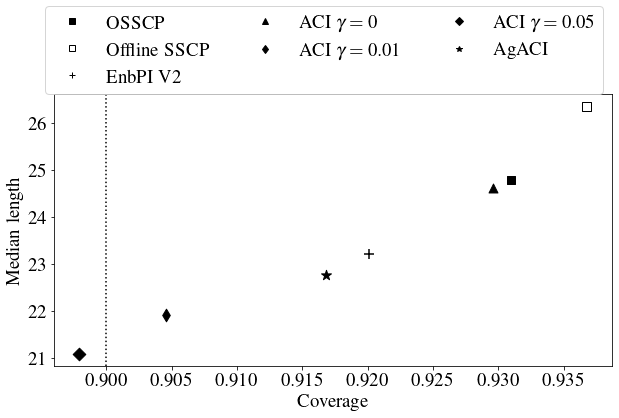

In [23]:
lines = False
add_offline = True

methods = ['CP', 'EnbPI_Mean', 'ACP_0','ACP_0.01', 'ACP_0.05', 'Aggregation_BOA_Gradient']
marker_size = 80
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5), sharex=True, sharey=True)
markers = {'Gaussian': "o", 'CP': "s", 'ACP':'D','ACP_0.05':'D', 'ACP_0.01': "d", 'ACP_0': "^", 'Aggregation_BOA_Gradient':'*',
           'QR': "v", 'CQR': "D", 'CQR_CV': "d", 'EnbPI': 'x','EnbPI_Mean': '+'}
methods_display = {'Gaussian': 'Gaussian', 'CP': 'OSSCP', # (adapted from Lei et al., 2018)
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)','EnbPI_Mean': 'EnbPI V2',
                   'ACP': 'ACI '+r'$\gamma = 0.05$',#(Gibbs \& Candès, 2021)
                   'ACP_0.05': 'ACI '+r'$\gamma = 0.05$',#(Gibbs \& Candès, 2021)
                   'ACP_0.01': 'ACI '+r'$\gamma = 0.01$',# (Gibbs \& Candès, 2021), 
                   'ACP_0': 'ACI '+r'$\gamma = 0$',# (Gibbs \& Candès, 2021), 
                   'Aggregation_BOA_Gradient':'AgACI'}

for method in methods:
    name_dir, name_method = files.get_name_results(method, dataset=dataset)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (Y <= results['Y_sup']) & (Y >= results['Y_inf'])
    lengths = results['Y_sup'] - results['Y_inf']
    if method not in ["ACP","ACP_0.01","ACP_QCP_0.05",'EnbPI_Mean', 'Aggregation_BOA_Gradient']:
        ax1.scatter(np.mean(contains),np.median(lengths), 
                    marker=markers[method], color='black',s=marker_size)
    elif method in ["ACP","ACP_0.01","ACP_QCP_0.05"]:
        ax1.scatter(np.mean(contains),np.median(lengths), 
                    marker=markers[method], color='black',s=marker_size)
    elif method in ['EnbPI_Mean','Aggregation_BOA_Gradient']:
         ax1.scatter(np.mean(contains),np.median(lengths), 
                     marker=markers[method], color='black',s=marker_size+30)
    if add_offline and method in ['Gaussian','CP','CQR','CQR_CV']:
        name_dir, name_method = files.get_name_results(method, online=False, dataset=dataset)
        results = files.load_file('results/'+name_dir, name_method, 'pkl')
        contains = (Y <= results['Y_sup']) & (Y >= results['Y_inf'])
        lengths = results['Y_sup'] - results['Y_inf']
        ax1.scatter(np.mean(contains),np.median(lengths), 
                    marker=markers[method], color='black', facecolors='none',s=marker_size)
ax1.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Median length")

# Methods legend

handles = []
names = []
names_wo_offline = list( map(methods_display.get, methods) )
if add_offline:
    names = np.append(names,names_wo_offline[0])
    names = np.append(names,names_wo_offline)
    names[1] = 'Offline SSCP'# (adapted from Lei et al., 2018)
else:
    names = names_wo_offlines
for marker in list( map(markers.get, methods) ):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and marker == 's':
        handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markerfacecolor='none'))

fig.legend(handles, names, bbox_to_anchor=(0,0.95,1,0.2), loc='upper center', ncol=3)

if lines:
    name_plot = 'plots/prices/'+dataset+'_lines'
else:
    name_plot = 'plots/prices/'+dataset+'_median'
if add_offline :
    name_plot = name_plot + '_offline'
#plt.savefig(name_plot+'.pdf', bbox_inches='tight',dpi=300)
plt.show()

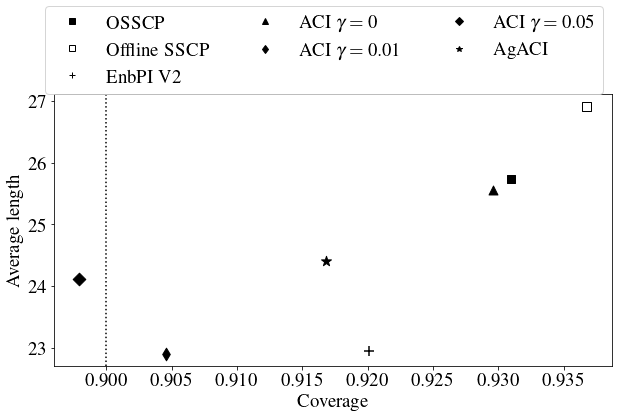

In [24]:
lines = False
add_offline = True

methods = ['CP', 'EnbPI_Mean', 'ACP_0','ACP_0.01', 'ACP_0.05', 'Aggregation_BOA_Gradient']
marker_size = 80
fig, (ax1) = plt.subplots(1, 1, figsize=(10,5), sharex=True, sharey=True)
markers = {'Gaussian': "o", 'CP': "s", 'ACP':'D','ACP_0.05':'D', 'ACP_0.01': "d", 'ACP_0': "^", 'Aggregation_BOA_Gradient':'*',
           'QR': "v", 'CQR': "D", 'CQR_CV': "d", 'EnbPI': 'x','EnbPI_Mean': '+'}
methods_display = {'Gaussian': 'Gaussian', 'CP': 'OSSCP', # (adapted from Lei et al., 2018)
                   'EnbPI': 'EnbPI (Xu \& Xie, 2021)','EnbPI_Mean': 'EnbPI V2',
                   'ACP': 'ACI '+r'$\gamma = 0.05$',#(Gibbs \& Candès, 2021)
                   'ACP_0.05': 'ACI '+r'$\gamma = 0.05$',#(Gibbs \& Candès, 2021)
                   'ACP_0.01': 'ACI '+r'$\gamma = 0.01$',# (Gibbs \& Candès, 2021), 
                   'ACP_0': 'ACI '+r'$\gamma = 0$',# (Gibbs \& Candès, 2021), 
                   'Aggregation_BOA_Gradient':'AgACI',
                   'ACP_QCP_0.05': 'ACI (Gibbs \& Candès, 2021) with corrected quantile',
                   'QR': 'QR (Koenker \& Bassett)', 'CQR': 'CQR (Romano et al., 2019)', 
                   'CQR_CV': 'CQR with CV (Romano et al., 2019)'}

# Get values for imputation
name_dir, name_method = files.get_name_results('ACP_0', dataset=dataset)
results = files.load_file('results/'+name_dir, name_method, 'pkl')
borne_sup = results['Y_sup']
borne_inf = results['Y_inf']
y_chap = (borne_sup+borne_inf)/2
abs_res = np.abs(Y - y_chap)
max_eps = np.max(abs_res)
val_max = y_chap+max_eps
val_min = y_chap-max_eps

for method in methods:
    name_dir, name_method = files.get_name_results(method, dataset=dataset)
    results = files.load_file('results/'+name_dir, name_method, 'pkl')
    contains = (Y <= results['Y_sup']) & (Y >= results['Y_inf'])
    lengths = results['Y_sup']-results['Y_inf']
    if method[:3] in ['ACP','Agg']:
        borne_sup = results['Y_sup']
        borne_inf = results['Y_inf']
        borne_sup[np.isinf(borne_sup)] = val_max[np.isinf(borne_sup)]
        borne_inf[np.isinf(borne_inf)] = val_min[np.isinf(borne_inf)]
        borne_sup[borne_sup > val_max] = val_max[borne_sup > val_max]
        borne_inf[borne_inf < val_min] = val_min[borne_inf < val_min]
        lengths = borne_sup-borne_inf
    if method not in ["ACP","ACP_0.01","ACP_QCP_0.05",'EnbPI_Mean', 'Aggregation_BOA_Gradient']:
        ax1.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color='black',s=marker_size)
    elif method in ["ACP","ACP_0.01","ACP_QCP_0.05"]:
        ax1.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color='black',s=marker_size)
    elif method in ['EnbPI_Mean','Aggregation_BOA_Gradient']:
         ax1.scatter(np.mean(contains),np.mean(lengths), 
                     marker=markers[method], color='black',s=marker_size+30)
    if add_offline and method in ['Gaussian','CP','CQR','CQR_CV']:
        name_dir, name_method = files.get_name_results(method, online=False, dataset=dataset)
        results = files.load_file('results/'+name_dir, name_method, 'pkl')
        contains = (Y <= results['Y_sup']) & (Y >= results['Y_inf'])
        lengths = results['Y_sup'] - results['Y_inf']
        ax1.scatter(np.mean(contains),np.mean(lengths), 
                    marker=markers[method], color='black', facecolors='none',s=marker_size)
ax1.axvline(x=1-alpha, color='black', ls=':')
ax1.set_xlabel("Coverage")
ax1.set_ylabel("Average length")

# Methods legend

handles = []
names = []
names_wo_offline = list( map(methods_display.get, methods) )
if add_offline:
    names = np.append(names,names_wo_offline[0])
    names = np.append(names,names_wo_offline)
    names[1] = 'Offline SSCP'# (adapted from Lei et al., 2018)
else:
    names = names_wo_offlines
for marker in list( map(markers.get, methods) ):
    handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None'))
    if add_offline and marker == 's':
        handles.append(mlines.Line2D([], [], color='black', marker=marker, linestyle='None', markerfacecolor='none'))

fig.legend(handles, names, bbox_to_anchor=(0,0.95,1,0.2), loc='upper center', ncol=3)
    
if lines:
    name_plot = 'plots/prices/'+dataset+'imputed_lines'
else:
    name_plot = 'plots/prices/'+dataset+'imputed_mean'
if add_offline :
    name_plot = name_plot + '_offline'
#plt.savefig(name_plot+'.pdf', bbox_inches='tight',dpi=300)
plt.show()